In [1]:
#@title Download Data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/housing_dataset.csv
print("Data downloaded successfully!")

Data downloaded successfully!


### Import libraries

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPool2D
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let us reuse the VGG16 network which has been trained on the ImageNet, which contains multiple classes of cats and dogs among other things.

We expect the convolution base to have learned features that help it identify cats and dogs.

Keras provides us with a pre-trained VGG16 network!



In [3]:
from tensorflow.keras.applications.vgg16 import VGG16

In [4]:
# Load the convolutional base
conv_base = VGG16(
    weights = "imagenet",
    include_top = False, # Don't re-use the classifier (top layers)
    input_shape = (180,180,3)
)

58889256/58889256 [==============================] - 4s 0us/step


In [5]:
# See a summary of the convolutional base
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

So how do we extract the features? Simple:

Pass the images through the convolutional base.

In [6]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/cats_vs_dogs_small.zip
!unzip -qq '/content/cats_vs_dogs_small.zip'

In [7]:
# defining path names for futur use
data_dir = '/content/cats_vs_dogs_small'

train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

### Converting the image dataset into a workable format

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
               train_path,
                image_size=(180, 180), # Resize the images to (180,180) 
                batch_size=32)
validation_dataset = image_dataset_from_directory(
                      validation_path,
                      image_size=(180, 180),
                      batch_size=32)
test_dataset = image_dataset_from_directory(
                test_path,
                image_size=(180, 180),
                batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Passing the dataset through Conv Base i.e forward pass through pre-trained weights

Before forward pass, Preprocessing the dataset specific to VGG16 is also required.

In [9]:
from tensorflow.keras.applications.vgg16 import preprocess_input # Importing function for preprocessing specific to the vgg16

In [10]:
# Extracting the features from pretrained models
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = preprocess_input(images) # preprocessing specific to the vgg16
        features = conv_base.predict(preprocessed_images)    # forward pass
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# Doing the same for all datasets
train_feature, train_labels = get_features_and_labels(train_dataset)
val_feature, val_labels = get_features_and_labels(validation_dataset)
test_feature, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


### Defining and training the densely connected classifier



In [11]:
# Q: Defining the classifier using the Functional API
inputs = Input(shape=(5,5,512))
x = Flatten()(inputs)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(1,activation="sigmoid")(x)
model_without_conv_base = Model(inputs,outputs)  ## Model is imported from keras while importing libraries

model_without_conv_base.compile(loss="binary_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

#### Call Back Function

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Define a function to return a commmonly used callback_list
def def_callbacks(filepath, mod_chk_mon = "val_loss", tensorboard = True, earlystop = 0 ):
    callback_list = []

    # Defualt callback
    callback_list.append(ModelCheckpoint(filepath,
                                         save_best_only = True,
                                         monitor=mod_chk_mon))
    if tensorboard:
      log_dir = "tensorLog_" + filepath
      callback_list.append(TensorBoard(log_dir=log_dir))

    if earlystop>0:
       callback_list.append(EarlyStopping(patience=earlystop))

    return callback_list

In [14]:
# fit the densely connected classsifier
history_wcb = model_without_conv_base.fit(
    train_feature,train_labels,     # Q: How did we get train_features? A: By forward-passing the images through the conv base
    epochs=20,
    validation_data=(val_feature,val_labels),
    callbacks =def_callbacks("feature_extraction.keras")
)

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 14.0956 - accuracy: 0.9200 - val_loss: 7.7153 - val_accuracy: 0.9580
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 3.6708 - accuracy: 0.9765 - val_loss: 5.8191 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.1168 - accuracy: 0.9840 - val_loss: 2.5947 - val_accuracy: 0.9800
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1537 - accuracy: 0.9885 - val_loss: 3.2172 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.4059 - accuracy: 0.9940 - val_loss: 3.3614 - val_accuracy: 0.9790
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4251 - accuracy: 0.9935 - val_loss: 9.2260 - val_accuracy: 0.9550
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4515 - accuracy: 0.9935 - val_loss: 2.7508 - val_accuracy: 0.9830
Epoch 8/20
63/63 [

Plotting Accuracy and Loss vs Epochs

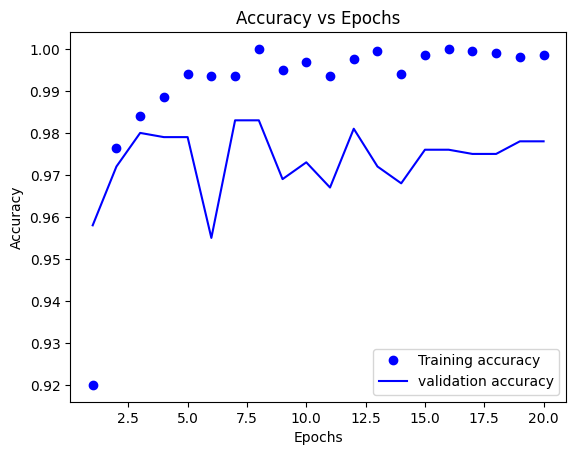

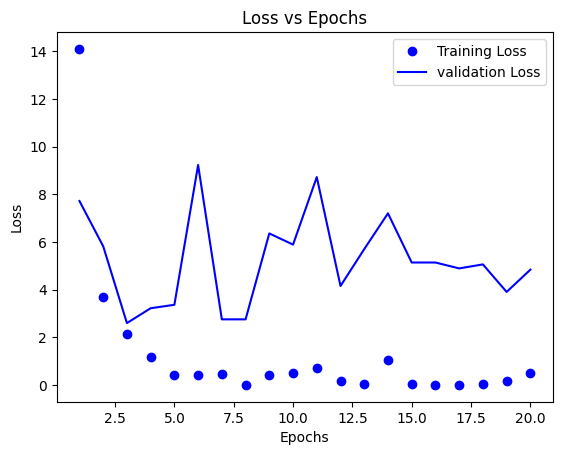

In [15]:
import pandas as pd
data = pd.DataFrame(history_wcb.history)
epochs = range(1,len(data)+1)
plt.plot(epochs,data['accuracy'],'bo',label="Training accuracy")
plt.plot(epochs,data['val_accuracy'],'b',label="validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.figure()
plt.plot(epochs,data['loss'],'bo',label="Training Loss")
plt.plot(epochs,data['val_loss'],'b',label="validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")

plt.show()

In [16]:
test_model = load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_feature,test_labels)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 4.0679 - accuracy: 0.9750
Test accuracy:0.975


The pretrained conv base + newly trained classification head has achieved roughly **97%** accuracy!

Remember, for convnet_from_scratch_with_data_augmentation, it was ~ 85%

For convnet_from_scratch, it was ~ 70%

## Fine tuning

The key idea here is to fine tune some top layers of the conv base as well.

We do so by freezing most of the bottom layers, leaving only a few top layers to train. Lets see:

In [17]:
# Load the convolutional base
conv_base = VGG16(
    weights = "imagenet",
    include_top = False, # Don't re-use the classifier (top layers)
    input_shape = (180,180,3)
)

In [18]:
#Define the model
inputs = Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

In [19]:
from tensorflow.keras.optimizers import RMSprop

In [20]:
#Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:   #[1,2,3,4,5,6,7,8,9]
    layer.trainable = False

#  Model compilation and summary
model.compile(loss="binary_crossentropy",
              optimizer=RMSprop(learning_rate=1e-5), # use low learning rate to not vary the weights drastically
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                           

In [21]:
## Callback function
callbacks = [ModelCheckpoint(filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss")]

In [22]:
## Training
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 158ms/step - loss: 4.0923 - accuracy: 0.8080 - val_loss: 0.9166 - val_accuracy: 0.9210
Epoch 2/30
63/63 [==============================] - 10s 154ms/step - loss: 0.8909 - accuracy: 0.9280 - val_loss: 0.6173 - val_accuracy: 0.9370
Epoch 3/30
63/63 [==============================] - 10s 152ms/step - loss: 0.3608 - accuracy: 0.9620 - val_loss: 0.5517 - val_accuracy: 0.9490
Epoch 4/30
63/63 [==============================] - 10s 153ms/step - loss: 0.1749 - accuracy: 0.9790 - val_loss: 0.4922 - val_accuracy: 0.9550
Epoch 5/30
63/63 [==============================] - 10s 154ms/step - loss: 0.1070 - accuracy: 0.9860 - val_loss: 0.4612 - val_accuracy: 0.9660
Epoch 6/30
63/63 [==============================] - 10s 156ms/step - loss: 0.0775 - accuracy: 0.9910 - val_loss: 0.4426 - val_accuracy: 0.9670
Epoch 7/30
63/63 [==============================] - 10s 156ms/step - loss: 0.0324 - accuracy: 0.9935 - val_loss: 0.4383 - val_accuracy: 0.9640

In [23]:
## Evaluation
model = load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# OPTIONAL EXERCISE: plot the losses by using appropriate callbacks and tensorboard

63/63 [==============================] - 6s 90ms/step - loss: 0.4797 - accuracy: 0.9685
Test accuracy: 0.969


# Using already run and saved models

For this save the model checkpoints in your drive (download the checkpoints and save to drive) give that path while loading. 

Mount your G drive:

In [24]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


For example, you downloaded the 'feature_extraction. keras' model and saved it in your drive inside a folder named 'model'. You can load it here like this: 

    model_saved_1 = load_model('/content/drive/MyDrive/model/feature_extraction.keras')

 In this case the file path is simply : '/content/feature_extraction.keras'

In [25]:
model_fewa = load_model('/content/feature_extraction.keras')

In [26]:
test_loss, test_acc = model_fewa.evaluate(test_feature, test_labels)
print(f"Test accuracy is:{test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 4.0679 - accuracy: 0.9750
Test accuracy is:0.975


Great! feature_extraction model has achieved **97%** accuracy!